## RFM Segmentation of an Ecommerce Company Customer Data

RFM segmentation is a great method to identify groups of customers for special treatment. It can be used to get better understanding of customers to improve customer marketing, which in turn could be used to increase the revenue of a company.
   - It allows marketers to target specific clusters of customers with communications that are much more relevant for their particular behaviour - and thus generate much higher rate of response, plus increased loyalty and customer lifetime value
  - R Recency, F frequency and M monetary.
  
- Recency (R): When was a customer's most recent activity or transaction with the company?

- Frequency (F): How often has a customer transacted or interacted with the brand during a particular period of time?

- Monetary (M): what is the size of the customer's transaction? / How much a customer has spent with the company during a particular period of time?


We will use this technique to gain a deeper understanding of the customers, allowing us to ask (and, more importantly, answer) the following important questions:

- How many different RFM segments do we have for users? What are the unique high-level characteristics of each segment? (By answering these questions, we can determine business levers that can be used to maximize revenue for each segment)

- What is the percentage of each RFM segment? (Answering this question helps one to size opportunities)

The data is an e-commerce dataset available at kaggle. It is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

link: https://www.kaggle.com/carrie1/ecommerce-data

### Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set the styles to seaborn 
sns.set()

from sklearn.cluster import KMeans

In [2]:
#%%timeit
#import data

data = pd.read_csv('/Users/st__morris/Downloads/sales_retail.csv')

### Data Preprocessing

In [3]:
#check the data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom


In [4]:
#check the shape of the data
data.shape

(541909, 8)

The data contains 541909 rows and 8 columns

In [5]:
#check for null values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data.InvoiceNo.describe()

count     541909
unique     25900
top       573585
freq        1114
Name: InvoiceNo, dtype: object

In [7]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/09/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/09/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/09/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/09/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/09/2011 12:50,4.95,12680.0,France


In [8]:
#remove null values
data = data.dropna(axis = 0, how= 'any')

In [9]:
#check for duplicates
data.duplicated().sum()

5225

In [10]:
#drop duplicates
data = data.drop_duplicates(ignore_index = True)

### Feature Engineering

we willl transform our raw data to the data with the appropriate format for the clustering analysis.

- we will convert
    - Convert **invoice_Date** column to the convenient datetime format
    - Create **transaction_amount** column by multiplying Quantity and UnitPrice
    - Convert **CustomerID** column to integer format

In [11]:
#Convert invoice_Date column to the convenient datetime format
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

#Create transaction_amount column by multiplying Quantity and UnitPrice
data['Transaction_Amount'] = data.Quantity * data.UnitPrice


#include only positive Transaction amount values (exclude credit)
data = data[data['Transaction_Amount']> 0]

# Cast CustomerID column to integer format
data.CustomerID = data.CustomerID.astype('int')

#### We are ready to construct a new dataframe for RFM segmentation. 
#### The dataframe key would be **Customer ID** with three columns as features, recency, frequency, and monetary.

#### Recency

Recency is defined as how long it has been (in months) since the user made the last transaction. 

We need to determine the current time reference that we will use for counting the months backward: we will set it as the most recent value of InvoiceData column.

In [12]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [13]:
#recency 
#create a dataframe of invoicedate and customerid, 
#then groupby customer id to select the max invoice 
#date of a customer to know how recent a customer's activity is

data_r = data[['InvoiceDate', 'CustomerID']].groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()



In [14]:
data_r.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:01:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [15]:
#set a current time
cur_time = data_r.InvoiceDate.max()

In [16]:
#calculate the month difference
def month_diff(cur_time, datetime_val):
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)

#create  a series containing the no of months
data_r['Recency'] = data_r.InvoiceDate.apply(lambda datetime_val: month_diff(cur_time, datetime_val))

In [17]:
data_r.head()

,CustomerID,InvoiceDate,Recency
0,12346,2011-01-18 10:01:00,11
1,12347,2011-12-07 15:52:00,0
2,12348,2011-09-25 13:13:00,3
3,12349,2011-11-21 09:51:00,1
4,12350,2011-02-02 16:01:00,10


In [18]:
data_r.shape

(4338, 3)

### we consider a customer to be absolutely churned if no transaction has been done in six months or more, so we have little interest in encoding the recency value if its greater than 6 months as it no longer has meaningful informations.

### we"ll clip the recency value to a maximum of 6 months.

In [19]:
#clip the recency values to 6 months. 
#nothing would be above 6, everything above 6 will become 6
#lower being the lowest threshold value and upper being the highest threshold value
data_r.Recency = data_r.Recency.clip(lower = None, upper = 6 )


#drop the invoice date, we now have our recency values.
data_r = data_r.drop('InvoiceDate', axis = 1)

#check the data
data_r.head()

,CustomerID,Recency
0,12346,6
1,12347,0
2,12348,3
3,12349,1
4,12350,6


### Now we have our Recency values, whats next is our frequncy and monetary values.

### we'll only consider from the last 6 months in other to get most meaningful information.

### Frequency: the number of transactions completed by the user in the previous six months.

### Monetary: the customer’s average transaction size for the last six months


*It is worth noting that this time period constraint is also advantageous in terms of computational standpoint. Assume you are working at Amazon to create the RFM segmentation. If you don’t limit the time window, you’ll end up using their more than two decades of transaction log data (which is supposedly too massive in size)*

In [20]:
data.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [22]:
#frequency and monetary for the last 6 months
#create a 6 months limit from the the latest date '2011-12-09'
earliest_date = pd.to_datetime('2011-06-09')

#selecting from data where InvoiceDate is greater than or equal to the earliest date
data_fm = data[data.InvoiceDate >= earliest_date]
data_fm = data[['InvoiceNo', 'CustomerID', 'Transaction_Amount']]

In [23]:
data_fm.head()

,InvoiceNo,CustomerID,Transaction_Amount
0,536365,17850,15.30
1,536365,17850,20.34
2,536365,17850,22.00
3,536365,17850,20.34
4,536365,17850,20.34


In [24]:
#frequency value and monetary value
data_fm = data_fm.groupby('CustomerID')[['InvoiceNo', 'Transaction_Amount']].agg({'InvoiceNo' : 'nunique', 'Transaction_Amount' : 'mean'}).reset_index()

#rename the columns
data_fm = data_fm.rename(columns = {'InvoiceNo': 'Frequency', 'Transaction_Amount' : 'Monetary'})

#round the monetary values to 2
data_fm['Monetary'] = data_fm['Monetary'].round(2)

data_fm.head()


,CustomerID,Frequency,Monetary
0,12346,1,77183.60
1,12347,7,23.68
2,12348,4,57.98
3,12349,1,24.08
4,12350,1,19.67


### now lets join the recency dataframe with the frequency and monetary to get our final data.

In [25]:
#merge the dataframes to get the final data
f_data = data_r.merge(data_fm, on = 'CustomerID', how = 'left')

f_data = f_data.fillna(0)

f_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,6,1,77183.60
1,12347,0,7,23.68
2,12348,3,4,57.98
3,12349,1,1,24.08
4,12350,6,1,19.67


In [26]:
f_data.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,2.632089,4.272015,68.381544
std,1721.808492,2.171291,7.697998,1467.918294
min,12346.000000,0.000000,1.000000,2.140000
25%,13813.250000,1.000000,1.000000,12.390000
50%,15299.500000,2.000000,2.000000,17.755000
75%,16778.750000,5.000000,5.000000,24.877500
max,18287.000000,6.000000,209.000000,77183.600000


It looks like we have some values in the monetary and frequency features that are way higher than other values in the feature, as the max value is far from the 75-quartile. they are referred to as outliers.

#### Removing outliers from the data

In [27]:
f_data.sort_values(by = 'Monetary')

,CustomerID,Recency,Frequency,Monetary
2315,15503,6,1,2.14
3995,17816,1,4,2.15
990,13684,6,1,2.25
697,13271,1,1,2.43
3590,17254,0,2,2.44
...,...,...,...,...
2087,15195,0,1,3861.00
2502,15749,6,3,4453.43
2011,15098,6,3,13305.50
3008,16446,0,2,56157.50


In [28]:
#99 percent quantile
q = f_data['Monetary'].quantile(0.95)


#creating a dataframe where we would keep only those values of price that are lower than 99 percentile
f_data_q = f_data[f_data['Monetary']< q]
f_data_q.describe()

,CustomerID,Recency,Frequency,Monetary
count,4121.000000,4121.000000,4121.000000,4121.000000
mean,15293.207717,2.620966,4.118175,20.131822
std,1716.175446,2.165033,7.348989,14.481576
min,12347.000000,0.000000,1.000000,2.140000
25%,13816.000000,1.000000,1.000000,11.750000
50%,15288.000000,2.000000,2.000000,17.320000
75%,16769.000000,5.000000,5.000000,22.990000
max,18287.000000,6.000000,209.000000,93.630000


In [29]:
#99 percent quantile
q = f_data['Monetary'].quantile(0.99)


#creating a dataframe where we would keep only those values of price that are lower than 99 percentile
f_data_q = f_data[f_data['Monetary']< q]
f_data_q.describe()

,CustomerID,Recency,Frequency,Monetary
count,4294.000000,4294.000000,4294.000000,4294.000000
mean,15293.917094,2.626688,4.242897,26.137347
std,1720.008218,2.166631,7.615278,35.596607
min,12347.000000,0.000000,1.000000,2.140000
25%,13811.250000,1.000000,1.000000,12.222500
50%,15283.500000,2.000000,2.000000,17.670000
75%,16775.750000,5.000000,5.000000,24.555000
max,18287.000000,6.000000,209.000000,363.360000


In [30]:
f_data = f_data_q 

## RFM segmentation via k-means clustering



### Standardize columns
This step is often skipped in many tutorials. However, it is best practice to standardize the R-F-M features, particularly since the monetary function has the measure of money, implying that the scales are substantially different from the other features. By standardizing it, we ensure that the K-means algorithm does not overvalue this monetary function (i.e., considering it as a more important feature than the other features).

In [34]:
#import sklearn's preprocessing.scale() to standardize the columns 
from sklearn.preprocessing import StandardScaler

#features column
features = ['Recency', 'Frequency', 'Monetary']

#standardized dataframe for training the model
standardized_data = f_data.copy()


#standardization
scaler = StandardScaler()
scaler.fit(f_data[features])
feat_scaled = scaler.transform(f_data[features])


#replace the existing values with the scaled values
standardized_data[features] = feat_scaled


In [35]:
standardized_data.head()

,CustomerID,Recency,Frequency,Monetary
1,12347,-1.212479,0.362091,-0.069041
2,12348,0.172321,-0.031900,0.894646
3,12349,-0.750879,-0.425890,-0.057803
4,12350,1.557120,-0.425890,-0.181706
5,12352,-0.750879,0.493421,0.093915


### Clustering (scaled data)

#### Take advantage of the elbow method to find the number of clusters to use for the model

In [36]:
wcss = []

no_cl = 10
for i in range(1, no_cl):
    kmeans = KMeans(i)
    kmeans.fit(standardized_data[features])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

#### The elbow method plot

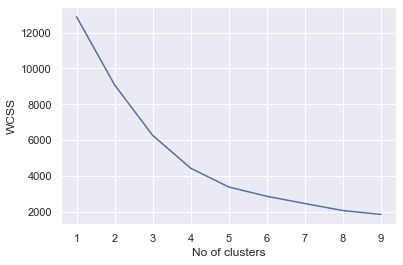

In [37]:
plt.plot(range(1,no_cl), wcss)

plt.xlabel('No of clusters')
plt.ylabel('WCSS')

plt.show()

Looking at the plot above, it is clear that we can select number of clusters to be 3: observe the large difference in slopes before and after this particular value of K, no of clusters.

### Now lets create our clusters

In [38]:
#using sklearn's k-means module with the number of clusters in bracket
kmeans = KMeans(3)
#fit the model with the input features
kmeans.fit(standardized_data[features])

#create a series of clusters and add as a column to the f_data dataframe

f_data['Cluster'] = kmeans.fit_predict(standardized_data[features])

In [39]:
f_data.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
1,12347,0,7,23.68,1
2,12348,3,4,57.98,1
3,12349,1,1,24.08,1
4,12350,6,1,19.67,0
5,12352,1,8,29.48,1


### Results Analysis
We must interpret the clusters after they have been collected. 
- To that end, we can summarize the obtained clusters by displaying their R-F-M centroid values as well as the number of users in each cluster.

#### Why centroid values? 
- Because we consider the values to be the representative of each obtained cluster. 
    - As a result, we can use these values to interpret the overall behavior/characteristics of users that belong to a specific cluster in terms of the corresponding user aspect (R/F/M).


In [40]:
#lets look at the centroids per clusters

centroid = f_data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'CustomerID']].agg({'Recency': 'mean', 'Frequency' : 'mean', 'Monetary': 'mean', 'CustomerID': 'nunique'}).reset_index()

centroid = centroid.rename(columns = {'CustomerID': 'Num_of_buyers'})

In [41]:
centroid.sort_values(by = 'Frequency', ascending = False)

,Cluster,Recency,Frequency,Monetary,Num_of_buyers
2,2,2.546053,14.644737,174.218816,152
1,1,1.296452,4.801194,20.295985,2847
0,0,5.560618,1.794595,21.598332,1295


In [42]:
centroid

,Cluster,Recency,Frequency,Monetary,Num_of_buyers
0,0,5.560618,1.794595,21.598332,1295
1,1,1.296452,4.801194,20.295985,2847
2,2,2.546053,14.644737,174.218816,152


According to the table above, we have three user clusters/segments:

Cluster 2: Our top segment of users. Users in this category are current regular buyers (recency low, frequency high). Their most recent transaction was only a few days ago, with a frequency of 15 transactions in the previous six months. Unfortunately, there are just a handful of them (152 users, equivalent to 3.5 percent of all user base).

Cluster 0: Our churned segment of users. Users in this category are our opt-out customers (recency high [note this is a bad thing], frequency low). Their last transaction was more than five months ago, with just 1 or 2 transaction in the previous six months! They are also, unfortunately, many (1295 users, equivalent to 30.2 percent of all user base).

Cluster 1: Our casual segment of users. Users in this category are our regular customers (modest on both recency and frequency). Their most recent transaction was within the last two months, with a frequency of up to three transactions in the previous six months. They are, as is widely observed, the largest portion of our user base (2847 users, equivalent to 66.3 percent of all user base)

In [43]:
#remove clusters column
centroid.pop('Cluster')

# name each cluster
cluster_names = ['Churned Buyers', 'Casual Buyers', 'Top Buyers']
centroid['ClusterName'] = cluster_names
centroid

,Recency,Frequency,Monetary,Num_of_buyers,ClusterName
0,5.560618,1.794595,21.598332,1295,Churned Buyers
1,1.296452,4.801194,20.295985,2847,Casual Buyers
2,2.546053,14.644737,174.218816,152,Top Buyers


## Actionable steps

- We will create a customized promotion strategy for each cluster based on the understanding of the above clusters, as follows:
    - Top buyers: There is no need to overwhelm them with vouchers/promotions (this saves us money), but we can optimize/leverage some kind of loyalty points to keep them around.
    - Casual buyers: We need to increase the frequency and monetary value of this segment. We can accomplish this by providing vouchers in the form of cashback (to enable repeat purchases), with a high eligibility threshold (e.g., the voucher is only valid for transaction amount over a certain amount).
    - Churned buyers: Our top priority is to get them transacting with us again after they’ve been churned for a while. To encourage them to do so, we could offer one or two large-benefit vouchers. This goes hand in hand with a steady stream of push notifications.

### We performed an RFM segmentation (in the e-commerce setting), in an end-to-end way! 
- We began by performing thorough data preprocessing, 
- which was followed by properly fitting the K-means algorithm (incorporating feature standardization and the Elbow method). Finally, 
- we interpreted the resulting segments in order to develop a personalized promotion plan for each segment.